**Общая информация**

**Срок сдачи:** 21 октября 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_validate

from scipy.spatial.distance import minkowski
from scipy.spatial.distance import cdist
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import TfidfVectorizer

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    def __init__(self, n_neighbors=2, algorithm='brute', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric
        self.w = 1.0/self.n_neighbors*np.ones(self.n_neighbors)
    
    def fit(self, X, y):
        self.y = y
        if self.algorithm == 'brute':
            self.X = X
        if self.algorithm == 'kd_tree':
            self.tree = KDTree(X, metric=self.metric)
    
    def predict(self, X):
        Y = []
        if self.algorithm == 'brute':
            if self.metric == 'euclidean':
                Z = cdist(X, self.X, metric='euclidean')
            if self.metric == 'cosine':
                Z = 1-cosine_similarity(X,self.X)
            for r in Z:
                M = -np.inf
                ind = np.argpartition(-r, -self.n_neighbors)[-self.n_neighbors:]
                for e in self.y[ind]:
                    ind2 = (self.y[ind] == e)
                    if (self.w[ind2]).sum()>M:
                        M = self.w[ind2].sum()
                        ans = e
                Y.append(ans)
        if self.algorithm == 'kd_tree':
            for x in X:
                r, ind = self.tree.query(x.reshape(1,-1), k=self.n_neighbors)
                M = -np.inf
                for e in np.unique(self.y[ind]):
                    ind2 = (self.y[ind] == e).flatten()
                    if self.w[ind2].sum()>M:
                        M = self.w[ind2].sum()
                        ans = e
                Y.append(ans)
        return Y

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=1, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=1, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) - accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

In [8]:
%time clf.fit(X_train, y_train)

Wall time: 0 ns


KNeighborsClassifier(algorithm='brute', n_neighbors=1)

In [9]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [10]:
%time clf.predict(X_test)

Wall time: 1 ms


array([0, 1, 2, 0, 0, 0, 2, 1, 2, 1, 1, 0, 1, 2, 2])

In [11]:
%time my_clf.predict(X_test)

Wall time: 0 ns


[0, 1, 2, 0, 0, 0, 2, 1, 2, 1, 1, 0, 1, 2, 2]

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [12]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [14]:
%time clf.fit(X_train, y_train)

Wall time: 0 ns


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [15]:
%time my_clf.fit(X_train, y_train)

Wall time: 1 ms


In [16]:
%time clf.predict(X_test)

Wall time: 2 ms


array([2, 2, 1, 2, 1, 0, 0, 0, 2, 0, 1, 1, 1, 0, 2])

In [17]:
%time my_clf.predict(X_test)

Wall time: 1 ms


[2, 2, 1, 2, 1, 0, 0, 0, 2, 0, 1, 1, 1, 0, 2]

In [18]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [19]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [20]:
cnt = 2000 #если брать всё, то работает долго
data = newsgroups['data'][:cnt] 
target = newsgroups['target'][:cnt]

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [21]:
alpha = 0.005 #0.1, чтобы работало быстрее
vectorizer = CountVectorizer(min_df = alpha) 
X = (vectorizer.fit_transform(data)).toarray()

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [22]:
my_clf = MyKNeighborsClassifier(algorithm='brute', metric="cosine")
cross_validate(my_clf, X, target, cv=3, scoring="accuracy")['test_score']

array([0.13043478, 0.14542729, 0.1036036 ])

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [23]:
def best_k(metr, vectoriz):
    ans = -1
    best_p = 0
    P = []
    if vectoriz == 'count':
        vectorizer = CountVectorizer(min_df = alpha)
    if vectoriz == 'tfid':
        vectorizer = TfidfVectorizer(min_df = alpha) 
    X = (vectorizer.fit_transform(data)).toarray()
    for n in range(1,15):
        my_clf = MyKNeighborsClassifier(n_neighbors=n, metric=metr)
        p = cross_validate(my_clf, X, target, cv=3, scoring="accuracy")['test_score'].mean()
        if (p > best_p):
            best_p = p
            ans = n
        P.append(p)
    plt.plot(range(1,15), P)
    return ans, best_p

(9, 0.13349706528117325)

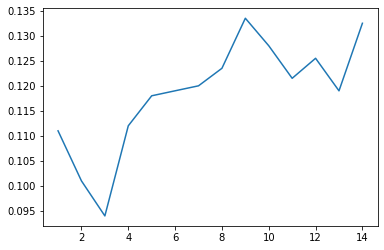

In [24]:
best_k('euclidean', 'count')

(1, 0.1699885792839316)

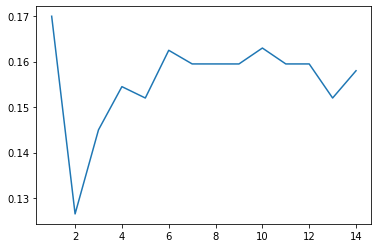

In [25]:
best_k('cosine', 'count')

(1, 0.1034985510247879)

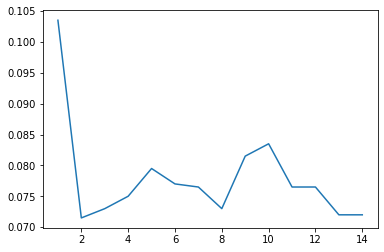

In [26]:
best_k('euclidean', 'tfid')

(14, 0.3704986845916381)

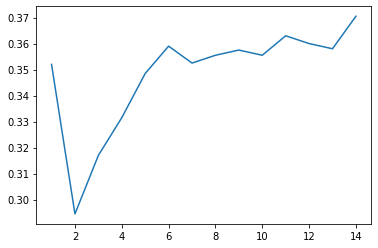

In [27]:
best_param = best_k('cosine', 'tfid')
best_param

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [28]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])
data_test = newsgroups['data'][:cnt]
target_test = newsgroups['target'][:cnt]

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [29]:
vectorizer2 = TfidfVectorizer(min_df = alpha) 
vectorizer2.fit_transform(data_test)
vectorizer = CountVectorizer(min_df = alpha) 
vectorizer.fit_transform(data)
unit_vocabulary = list(set(vectorizer.get_feature_names() + vectorizer2.get_feature_names()))
#этот код нужен для учёта различия словарей в тесте и обучении

vectorizer2 = TfidfVectorizer(min_df = alpha, vocabulary = unit_vocabulary) 
X_test = vectorizer2.fit_transform(data_test).toarray()
vectorizer = CountVectorizer(min_df = alpha, vocabulary = unit_vocabulary) 
X = vectorizer.fit_transform(data).toarray()
best_my_clf = MyKNeighborsClassifier(n_neighbors = best_param[0], metric='cosine')
best_my_clf.fit(X,target)
cross_validate(best_my_clf, X_test, target_test, cv=3, scoring="accuracy")['test_score'].mean()

0.3349841595718657

In [30]:
'''
Качество на тестовой хуже, чем на валидации. 
Это объясняется тем, что на валидации я подбирал
структурный параметр "k", который как раз
максимизировал точность на валидации, то есть
в некотором смысле модель опять была переобучена
и потому показывала более плохой результат на тестовой
'''

'\nКачество на тестовой хуже, чем на валидации. \nЭто объясняется тем, что на валидации я подбирал\nструктурный параметр "k", который как раз\nмаксимизировал точность на валидации, то есть\nв некотором смысле модель опять была переобучена\nи потому показывала более плохой результат на тестовой\n'